In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.special import legendre
import scipy.sparse.linalg as sp
import seaborn as sns
from rich import *
from tqdm import tqdm
from types import FunctionType as function

sns.set()
sns.set_style("whitegrid")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

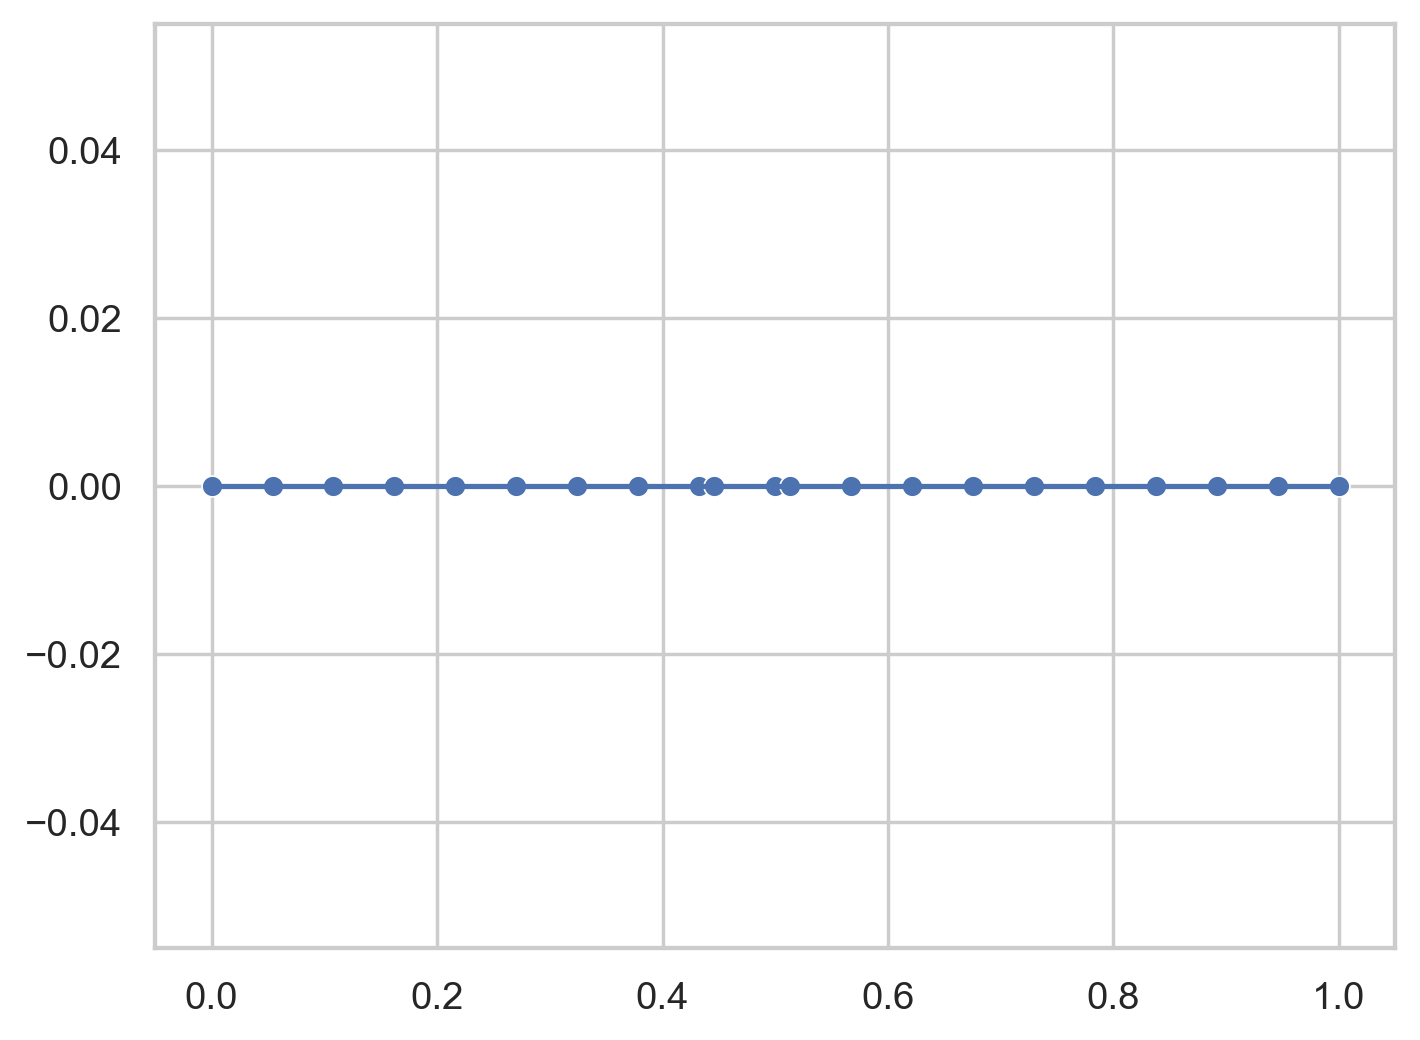

In [2]:
def do_op(f, xs):
    """
    `do_op(f, xs)` 

    Performs function `f` to every component of `xs` and returns the results in a vector.

    ### Parameters:
    `f`: a function that takes a scalar as input and returns a scalar.
    `xs`: a vector of scalars.

    ### Return:
    `results`: a vector of scalars, the result of applying `f` to every component of `xs`.
    """ 
    results = np.zeros(len(xs))
    for i in range(len(xs)):
        results[i] = f(xs[i])
    return results

# Problem setup
L:float     = 1.0  # Domain bounds
N:int       = 20  # Number of elements
p:int       = 4  # Polynomial degree
f:function  = lambda x: np.sin(2*np.pi*x)  # RHS function

def mesh_generator(L, N, alphas, positions):
    """
    `mesh_generator(L, N, alphas, positions)`
    
    Generate a cut-cell mesh in a 1D domain of length `L` with `N` elements.

    ### Parameters:
    `L`: length of the domain.
    `N`: Number of elements.
    `alphas`: a list containing the relative size of the cut cells (alpha \in [0,1]).
    `positions`: a list containing the positions of the cut cells (position \in [0,N]).

    ### Return:
    `nodes`: a 2D array of shape (2, N) containing the left and right nodes of the mesh.
    `h`: a scalar containing the full cell width.
    `h_local`: a 1D array of size N containing the width of each element.
    """
    assert np.size(alphas) == np.size(positions), "Incompatible size of alphas and positions"
    h = L / (N - np.size(alphas) + np.sum(alphas)) # global cell width
    nodes = np.linspace(0, N, N + 1) * h
    for i in range(np.size(alphas)):
        nodes[positions[i]:] -= h * (1-alphas[i])
    h_local = np.diff(nodes)
    nodes = np.array([nodes[0:-1], nodes[1:]])
    return nodes, h, h_local

nodes, h, h_local = mesh_generator(L, N, [1/4, 1/4], [N//2-1, N//2+1])
fig, ax = plt.subplots(dpi=250)
sns.scatterplot(x=np.append(nodes[0,:], [L]), y=np.zeros(N+1))
sns.lineplot(x=np.append(nodes[0,:], [L]), y=np.zeros(N+1))
plt.show()

In [3]:
def preprocess(nodes, h_local, h):
    """
    `preprocess(nodes, h_local, h)`
    
    Preprocess the mesh to prepare for state redistribution.
    
    ### Parameters:
    `nodes`: a 2D array of shape (2, N) containing the left and right nodes of the mesh.
    `h_local`: a 1D array of size N containing the width of each element.
    `h`: a scalar containing the full cell width.
    
    ### Return:
    `merged_nodes`: a 2D array of shape (2, N) containing the left and right nodes of the mesh after merging small cells.
    `overlap`: a list of lists, where each inner list contains the indices of the merged cells that overlap on each original cell.
    `merged_ind`: a list of lists, where each inner list contains the indices of the original cells are covered by each merged cell.
    """
    merged_nodes = np.zeros(np.shape(nodes))
    merged_ind = []
    overlap = [ [] for _ in range(N) ]
    for i in range(N):
        ind = []
        if h_local[i] >= 0.5 * h:
            merged_nodes[:, i] = nodes[:, i]
            overlap[i].append(i)
            ind.append(i)
        else: # not sure: what if two or more small cut cells are close?
            merged_nodes[0, i] = nodes[0, (i-1) % N]
            overlap[(i-1) % N].append(i)
            ind.append((i-1) % N)

            overlap[i].append(i)
            ind.append(i)

            merged_nodes[1, i] = nodes[1, (i+1) % N]
            overlap[(i+1) % N].append(i)
            ind.append((i+1) % N)
        
        merged_ind.append(ind)

    return merged_nodes, overlap, merged_ind

merged_nodes, overlap, merged_ind = preprocess(nodes, h_local, h)

overlap_counts = np.int64(do_op(len, overlap))
print("The merged nodes are: ")
print(merged_nodes)
print("Overlap counts are: ")
print(overlap_counts)
print("Each merged element contains the following cells: ")
print(merged_ind)

The merged nodes are:

[[0.         0.05405405 0.10810811 0.16216216 0.21621622 0.27027027
  0.32432432 0.37837838 0.37837838 0.44594595 0.44594595 0.51351351
  0.56756757 0.62162162 0.67567568 0.72972973 0.78378378 0.83783784
  0.89189189 0.94594595]
 [0.05405405 0.10810811 0.16216216 0.21621622 0.27027027 0.32432432
  0.37837838 0.43243243 0.5        0.5        0.56756757 0.56756757
  0.62162162 0.67567568 0.72972973 0.78378378 0.83783784 0.89189189
  0.94594595 1.        ]]

Overlap counts are:

[1 1 1 1 1 1 1 2 1 3 1 2 1 1 1 1 1 1 1 1]

Each merged element contains the following cells:

[
    [0],
    [1],
    [2],
    [3],
    [4],
    [5],
    [6],
    [7],
    [7, 8, 9],
    [9],
    [9, 10, 11],
    [11],
    [12],
    [13],
    [14],
    [15],
    [16],
    [17],
    [18],
    [19]
]

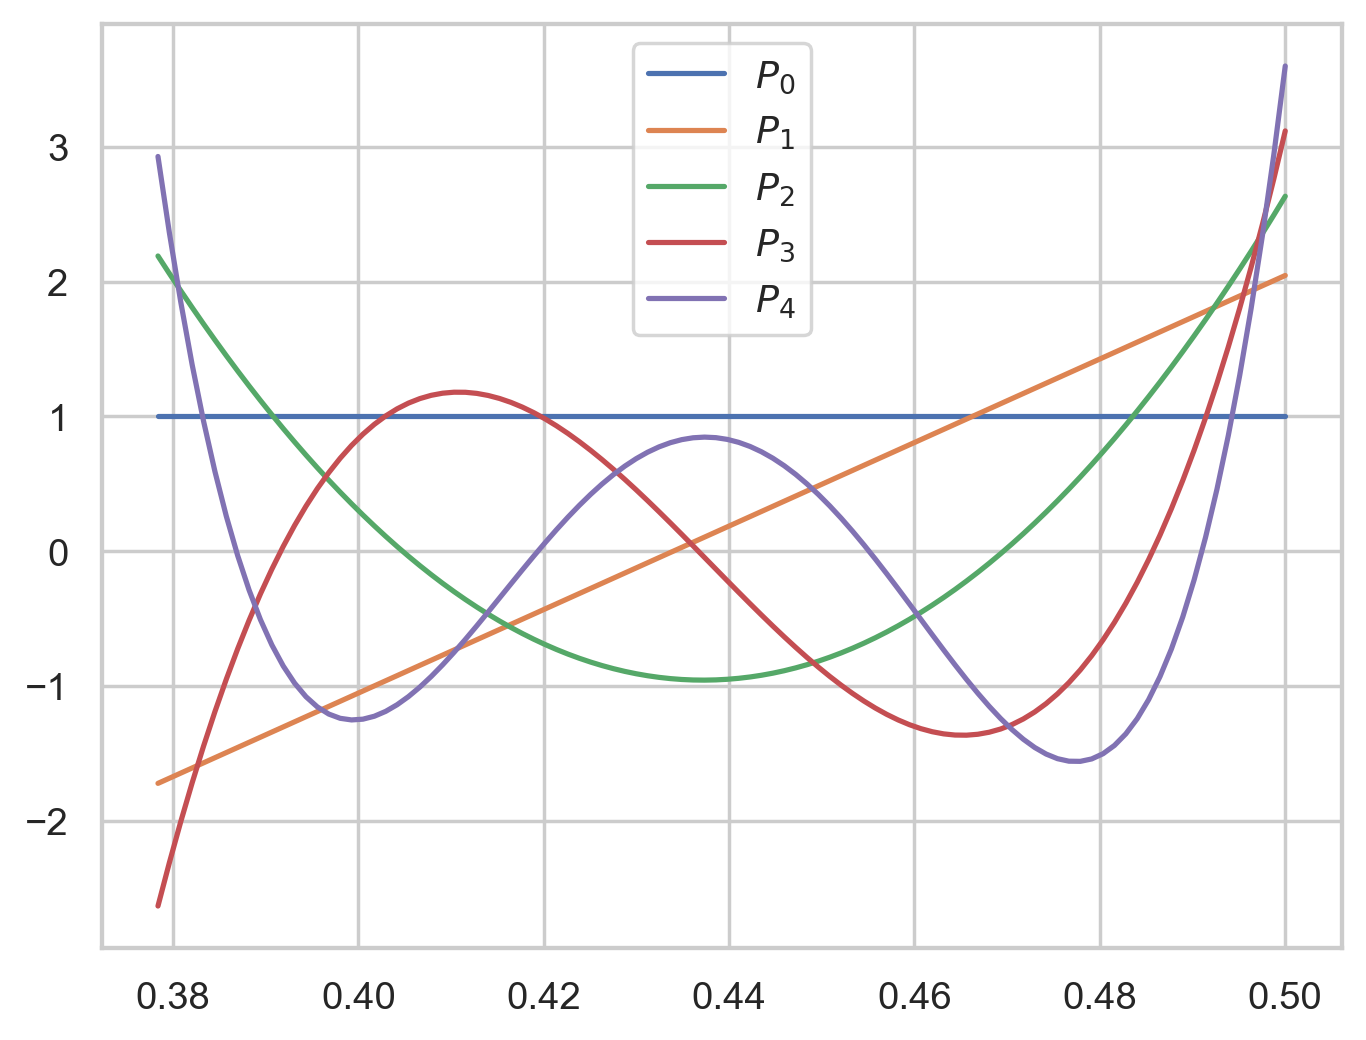

In [4]:
def weighted_inner(f:function, g:function, ind, h_local, overlap_counts, nodes):
    """
    `weighted_inner(f, g, ind, h_local, overlap_counts, nodes)`
    
    Performs a weighted inner product between two functions `f` and `g` on the merged mesh cell which covers the original cells that are indexed by `ind`.
    
    ### Parameters:
    `f`: a function that takes a scalar as input and returns a scalar.
    `g`: a function that takes a scalar as input and returns a scalar.
    `ind`: a list containing the indices of the original cells that are covered by the merged cell.
    `h_local`: a 1D array of size N containing the width of each element.
    `overlap_counts`: a 1D array of size N containing the number of merged cells that overlap on each original cell.
    `nodes`: a 2D array of shape (2, N) containing the left and right nodes of the mesh.
    
    ### Return:
    `result`: a scalar, the weighted inner product between `f` and `g` on the merged mesh cell.
    """
    H = 0
    result = 0
    func = lambda x: f(x) * g(x)
    for i in ind:
        H += h_local[i] / overlap_counts[i]
        result += integrate.quad(func, nodes[0, i], nodes[1, i])[0] / overlap_counts[i]
    return result / H

def find_basis(ind, h_local, overlap_counts, nodes, p):
    """
    `find_basis(ind, h_local, overlap_counts, nodes, p)`
    
    Performs Gram-Schmidt to find the basis functions for the merged mesh cell which covers the original cells that are indexed by `ind`.
    
    ### Parameters:
    `ind`: a list containing the indices of the original cells that are covered by the merged cell.
    `h_local`: a 1D array of size N containing the width of each element.
    `overlap_counts`: a 1D array of size N containing the number of merged cells that overlap on each original cell.
    `nodes`: a 2D array of shape (2, N) containing the left and right nodes of the mesh.
    `p`: a scalar, the polynomial degree.
    
    ### Return:
    `Polys`: a list of functions, the basis functions for the merged mesh cell.
    """
    Polys = []
    for i in range(p+1):
        Pi = legendre(i)
        for j in range(i):
            Pi = Pi - Polys[j] * weighted_inner(Pi, Polys[j], ind, h_local, overlap_counts, nodes)
        Pi = Pi / np.sqrt(weighted_inner(Pi, Pi, ind, h_local, overlap_counts, nodes))
        Polys.append(Pi)
    return Polys

Polys = find_basis(merged_ind[N//2-2], h_local, overlap_counts, nodes, p)

refined_x = np.linspace(merged_nodes[0, N//2-2], merged_nodes[1, N//2-2], 100)
fig, ax = plt.subplots(dpi=250)
for i in range(p+1):
    ax.plot(refined_x, Polys[i](refined_x), label=f"$P_{i}$")
ax.legend()
plt.show()

In [5]:
def find_local_basis(merged_ind, h_local, overlap_counts, nodes, p):
    """
    `find_local_basis(merged_ind, h_local, overlap_counts, nodes, p)`
    
    Find the basis function for each merged cell.
    
    ### Parameters:
    `merged_ind`: a list of lists, where each inner list contains the indices of the original cells that are covered by each merged cell.
    `h_local`: a 1D array of size N containing the width of each element.
    `overlap_counts`: a 1D array of size N containing the number of merged cells that overlap on each original cell.
    `nodes`: a 2D array of shape (2, N) containing the left and right nodes of the mesh.
    `p`: a scalar, the polynomial degree.
    
    ### Return:
    `local_basis`: a list of lists, where each inner list contains the basis functions for each merged cell.
    """
    local_basis = []
    for i in range(N):
        local_basis.append(find_basis(merged_ind[i], h_local, overlap_counts, nodes, p))
    return local_basis

local_basis = find_local_basis(merged_ind, h_local, overlap_counts, nodes, p)
print("The local basis functions are:")
print(local_basis)

The local basis functions are:

[
    [
        poly1d([1.]),
        poly1d([64.08587988, -1.73205081]),
        poly1d([ 4.59176559e+03, -2.48203546e+02,  2.23606798e+00]),
        poly1d([ 3.35038103e+05, -2.71652516e+04,  5.87356791e+02, -2.64575131e+00]),
        poly1d([ 2.45983631e+07, -2.65928250e+06,  9.24075000e+04, -1.11000000e+03,
        3.00000000e+00])
    ],
    [
        poly1d([1.]),
        poly1d([64.08587988, -5.19615242]),
        poly1d([4591.7655918 , -744.61063651,   29.06888371]),
        poly1d([ 3.35038103e+05, -8.14957548e+04,  6.46092470e+03, -1.66682333e+02]),
        poly1d([ 2.45983631e+07, -7.97784750e+06,  9.54877500e+05, -4.99500000e+04,
        9.63000000e+02])
    ],
    [
        poly1d([1.]),
        poly1d([64.08587988, -8.66025404]),
        poly1d([ 4591.7655918 , -1241.01772751,    82.73451517]),
        poly1d([ 335038.10289839, -135826.25793178,   18208.06052275,
          -806.95414987]),
        poly1d([ 2.45983631e+07, -1.32964125e+07,  2.67981750e+06, -2.38650000e+05,
        7.92300000e+03])
    ],
    [
        poly1d([1.]),
        poly1d([ 64.08587988, -12.12435565]),
        poly1d([ 4591.7655918 , -1737.42481852,   163.23296236]),
        poly1d([ 335038.10289836, -190156.76110447,   35828.76425443,
         -2240.95136047]),
        poly1d([ 24598363.12501797, -18614977.50000881,   5267227.50000072,
         -660449.99999982,     30962.99999998])
    ],
    [
        poly1d([1.]),
        poly1d([ 64.08587988, -15.58845727]),
        poly1d([ 4591.7655918 , -2233.83190952,   270.56422528]),
        poly1d([ 335038.1028984 , -244487.26427722,   59323.0358967 ,
         -4786.16412172]),
        poly1d([ 24598363.12505304, -23933542.50005293,   8717107.5000203 ,
        -1408590.00000353,     85203.00000024])
    ],
    [
        poly1d([1.]),
        poly1d([ 64.08587988, -19.05255888]),
        poly1d([ 4591.7655918 , -2730.23900053,   404.72830393]),
        poly1d([ 335038.10289824, -298817.76744977,   88690.87544946,
         -8760.08259093]),
        poly1d([ 24598363.12502297, -29252107.49998857,  13029457.49997703,
        -2576309.9999918 ,    190802.99999911])
    ],
    [
        poly1d([1.]),
        poly1d([ 64.08587988, -22.5166605 ]),
        poly1d([ 4591.7655918 , -3226.64609153,   565.72519831]),
        poly1d([ 335038.1028983 , -353148.27062254,  123932.28291286,
        -14480.19692545]),
        poly1d([ 24598363.1249156 , -34570672.49988616,  18204277.4999428 ,
        -4256849.9999873 ,    372962.99999895])
    ],
    [
        poly1d([1.]),
        poly1d([ 64.08587988, -25.98076211]),
        poly1d([ 4591.7655918 , -3723.05318254,   753.55490842]),
        poly1d([ 335038.10289825, -407478.77379515,  165047.25828675,
        -22263.9972826 ]),
        poly1d([ 24598363.12582879, -39889237.50131476,  24241567.50077952,
        -6543450.00020469,    661923.00002008])
    ],
    [
        poly1d([1.]),
        poly1d([ 30.98259461, -13.44618841]),
        poly1d([ 909.88960529, -795.58187128,  172.95143785]),
        poly1d([ 31758.81198534, -41731.06141583,  18207.90197924,  -2637.91961517]),
        poly1d([  977960.16335219, -1713692.17968577,  1123129.42953062,
        -326283.05628877,    35451.78202878])
    ],
    [
        poly1d([1.]),
        poly1d([ 64.08587988, -30.31088913]),
        poly1d([ 4591.7655918 , -4343.56204629,  1026.07569318]),
        poly1d([ 335038.10289817, -475391.90276091,  224700.68237835,
        -35379.4826099 ]),
        poly1d([ 24598363.12550786, -46537443.75095516,  33001028.43817371,
       -10396017.18771121,   1227537.25783733])
    ],
    [
        poly1d([1.]),
        poly1d([ 30.98259461, -15.86167136]),
        poly1d([ 909.88960529, -925.8308955 ,  234.55570607]),
        poly1d([ 31758.81198534, -48395.29692094,  24511.90853814,  -4126.34565115]),
        poly1d([  977960.16335081, -1986697.62758949,  1510502.02453095,
        -509410.13293976,    64294.88696099])
    ],
    [
        poly1d([1.]),
        poly1d([ 64.08587988, -34

In [6]:
def initialize(f, nodes, h_local, p):
    """
    `initialize(f, nodes, h_local, p)`
    
    Initialize the solution $u_0(x)$ using the given initial condition `f`.
    
    ### Parameters:
    `f`: a function that takes a scalar as input and returns a scalar.
    `nodes`: a 2D array of shape (2, N) containing the left and right nodes of the mesh.
    `h_local`: a 1D array of size N containing the width of each element.
    `p`: a scalar, the polynomial degree.
    
    ### Return:
    `U`: a 2D array of shape (N, p+1) containing the coefficients of the basis functions.
    """
    N = np.shape(nodes)[1]
    U = np.zeros((N, p+1))
    for i in range(N):
        for j in range(p+1):
            # Legendre polynomial normalization factor
            phi = lambda x: np.sqrt((2*j+1)/h_local[i]) * legendre(j)(2*(x - (nodes[0, i] + nodes[1, i]) / 2) / h_local[i])
            # Adjusted function for projection onto the j-th Legendre polynomial
            func = lambda x: f(x) * phi(x)
            # Project and normalize
            U[i, j] = integrate.quad(func, nodes[0, i], nodes[1, i])[0]
    return U

def evaluate_sol(U, h_local, nodes):
    """
    `evaluate_sol(U, h_local, nodes)`
    
    Returns a function `f` which takes in the position `x` and evaluates the solution value at that point.
    
    ### Parameters:
    `U`: a 2D array of shape (N, p+1) containing the coefficients of the basis functions.
    `h_local`: a 1D array of size N containing the width of each element.
    `nodes`: a 2D array of shape (2, N) containing the left and right nodes of the mesh.
    
    ### Return:
    `f`: a function that takes in the position `x` and evaluates the solution value at that point.
    """
    def f(x):
        u = 0
        index = 0
        while x > nodes[1, index]:
            index += 1
        coeffs = U[index, :]
        psi = (x - (nodes[0, index] + nodes[1, index]) / 2) * 2 / h_local[index]
        for j in range(p+1):
            u += np.sqrt((2*j+1)/h_local[index]) * legendre(j)(psi) * coeffs[j]
        return u
    return f

In [7]:
coarsen_M = []
for i in range(N):
    M = np.zeros((p+1, (p+1) * len(merged_ind[i])))
    H = 0
    for K in range(len(merged_ind[i])):
        k = merged_ind[i][K]
        H += h_local[k] / overlap_counts[k]
        for j in range(p+1):
            merged_basis = local_basis[i][j]            
            for l in range(p+1):
                unmerged_basis = lambda x: np.sqrt((2*l+1)/h_local[k]) * legendre(l)(2*(x - (nodes[0, k] + nodes[1, k]) / 2) / h_local[k])
                func = lambda x: merged_basis(x) * unmerged_basis(x)
                M[j, K * (p+1) + l] = integrate.quad(func, nodes[0, k], nodes[1, k])[0] / overlap_counts[k]
    coarsen_M.append(M / H)

def Coarsen(U, merged_ind, p, coarsen_M):
    """
    `Coarsen(U, merged_ind, p, coarsen_M)`
    
    Performs the coarsening step of the state redistribution method.
    
    ### Parameters:
    `U`: a 2D array of shape (N, p+1) containing the coefficients of the basis functions.
    `merged_ind`: a list of lists, where each inner list contains the indices of the original cells that are covered by each merged cell.
    `p`: a scalar, the polynomial degree.
    `coarsen_M`: a list of local coarsening matrices, where each local coarsening matrix is a matrix of shape (p+1, (p+1) * len(merged_ind[i])).
    
    ### Return:
    `Q`: a 2D array of shape (N, p+1) containing the coefficients of the basis functions on the merged cells.
    """
    Q = np.zeros(np.shape(U))
    for i in range(N):
        c = np.zeros((p+1) * len(merged_ind[i]))
        for K in range(len(merged_ind[i])):
            k = merged_ind[i][K]
            c[K * (p+1): (K+1) * (p+1)] = U[k, :]
        Q[i, :] = coarsen_M[i] @ c
    return Q

redistribute_M = []
for i in range(N):
    M = np.zeros((p+1, (p+1) * overlap_counts[i]))
    H = h_local[i]
    for k in range(overlap_counts[i]):
        for j in range(p+1):
            unmerged_basis = lambda x: np.sqrt((2*j+1)/h_local[i]) * legendre(j)(2*(x - (nodes[0, i] + nodes[1, i]) / 2) / h_local[i])
            for l in range(p+1):
                merged_basis = local_basis[overlap[i][k]][l]
                func = lambda x: merged_basis(x) * unmerged_basis(x)
                M[j, k * (p+1) + l] = integrate.quad(func, nodes[0, i], nodes[1, i])[0] / overlap_counts[i]
    redistribute_M.append(M)

def Redistribute(Q, overlap, overlap_counts, p, redistribute_M):
    """
    `Redistribute(Q, overlap, overlap_counts, p, redistribute_M)`
    
    Performs the redistribution step of the state redistribution method.
    
    ### Parameters:
    `Q`: a 2D array of shape (p+1, N) containing the coefficients of the basis functions on the merged cells.
    `overlap`: a list of lists, where each inner list contains the indices of the merged cells that overlap on each original cell.
    `overlap_counts`: a 1D array of size N containing the number of merged cells that overlap on each original cell.
    `p`: a scalar, the polynomial degree.
    `redistribute_M`: a list of local redistribution matrices, where each local coarsening matrix is a matrix of shape (p+1, (p+1) * overlap_counts[i]).
    
    ### Return:
    `U_SRD`: a 2D array of shape (p+1, N) containing the coefficients of the basis functions on the base grid after state redistribution 🍻.
    """
    U_SRD = np.zeros(np.shape(Q))
    for i in range(N):
        c = np.zeros((p+1) * overlap_counts[i])
        for k in range(overlap_counts[i]):
            c[k * (p+1): (k+1) * (p+1)] = Q[overlap[i][k], :]
        U_SRD[i, :] = redistribute_M[i] @ c
    return U_SRD

In [8]:
K = np.zeros((p+1, p+1))
phi_l = np.zeros(p+1)
phi_r = np.zeros(p+1)
for i in range(p+1):
    phi1 = lambda x: np.sqrt(2*i+1)*legendre(i)(x)
    phi_l[i] = phi1(-1)
    phi_r[i] = phi1(1)
    for j in range(p+1):
        # Stiffness matrix with correct normalization and derivative scaling
        phi2p = lambda x : np.sqrt(2*j+1)*np.polyder(legendre(j))(x)
        K[j, i] = integrate.quad(lambda x: phi1(x) * phi2p(x), -1, 1)[0] # Notice here K is NOT symmetric!!!

def local_K(h):
    return K / h

def local_phi_l(h):
    return phi_l / np.sqrt(h)

def local_phi_r(h):
    return phi_r / np.sqrt(h)


In [9]:
def compute_Q(U, srd=True):
    Q = np.zeros(np.shape(U))
    N = np.size(U, 0)
    
    U_left = np.zeros(N+1)
    U_right = np.zeros(N+1)
    for j in range(N):
        U_left[j] = np.dot(U[j, :], local_phi_l(h_local[j]))
        U_right[j+1] = np.dot(U[j, :], local_phi_r(h_local[j])) 
    U_left[N] = -U_right[N]
    U_right[0] = -U_left[0]
    
    Flux = 0.5 * (U_left + U_right)
    for j in range(N):
        Q[j, :] = Flux[j+1] * local_phi_r(h_local[j]) - Flux[j] * local_phi_l(h_local[j])
        Q[j, :] -= local_K(h_local[j]) @ U[j, :]
    
    if srd:
        Q_SRD = Redistribute(Coarsen(Q, merged_ind, p, coarsen_M), overlap, overlap_counts, p, redistribute_M)
        Q = Q * np.array([h_local / h]).T + Q_SRD * np.array([1 - h_local / h]).T
    return Q

In [10]:
tau = 1

def compute_F(U, srd=True):
    F = np.zeros(np.shape(U))
    Q = compute_Q(U, srd)
    N = np.size(U, 0)
    
    U_left = np.zeros(N+1)
    U_right = np.zeros(N+1)
    Q_left = np.zeros(N+1)
    Q_right = np.zeros(N+1)
    for j in range(N):
        U_left[j] = np.dot(U[j, :], local_phi_l(h_local[j]))
        U_right[j+1] = np.dot(U[j, :], local_phi_r(h_local[j])) 
        Q_left[j] = np.dot(Q[j, :], local_phi_l(h_local[j]))
        Q_right[j+1] = np.dot(Q[j, :], local_phi_r(h_local[j])) 
    U_left[N] = -U_right[N]
    U_right[0] = -U_left[0]
    Q_left[N] = Q_right[N]
    Q_right[0] = Q_left[0]
    
    Flux = 0.5 * (Q_left + Q_right) + tau * (U_right - U_left)
    for j in range(N):
        F[j, :] = Flux[j+1] * local_phi_r(h_local[j]) - Flux[j] * local_phi_l(h_local[j])
        F[j, :] -= local_K(h_local[j]) @ Q[j, :]
    
    return F

Condition number of A is:

86960.91542255135

/var/folders/86/0dvym1n11pq3yfz2v0bcnv2h0000gn/T/ipykernel_77465/712577577.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


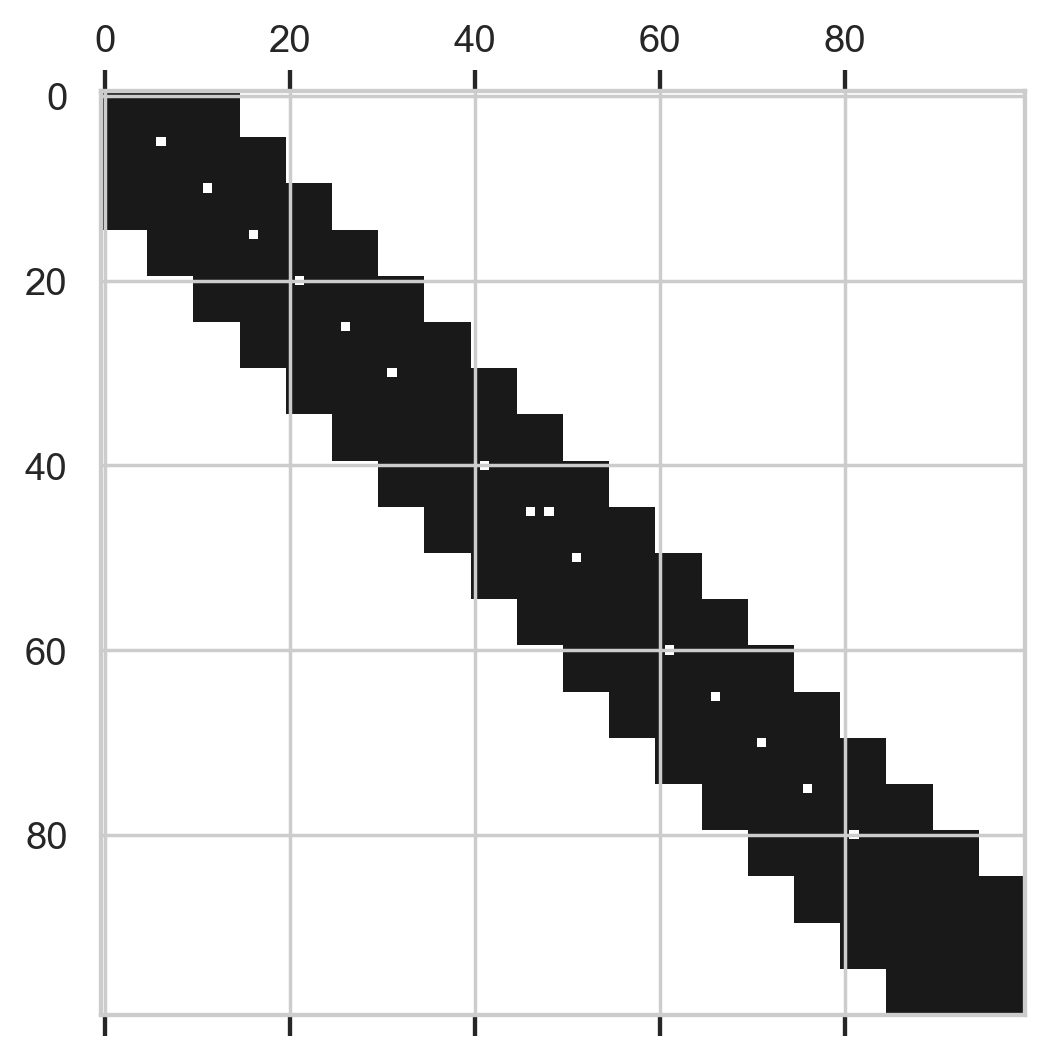

In [15]:
def mv(u):
    U = np.reshape(u, (N, p+1))
    F = compute_F(U, srd=False)
    return F.flatten()

A = sp.LinearOperator( (N*(p+1), N*(p+1)), matvec=mv )
Adense = A * np.eye(N*(p+1))
print("Condition number of A is:")
print(np.linalg.cond(Adense))
fig, ax = plt.subplots(dpi=250)
ax.spy(Adense)
fig.show()

Condition number of A is:

38910.212490491744

/var/folders/86/0dvym1n11pq3yfz2v0bcnv2h0000gn/T/ipykernel_77465/3184482821.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


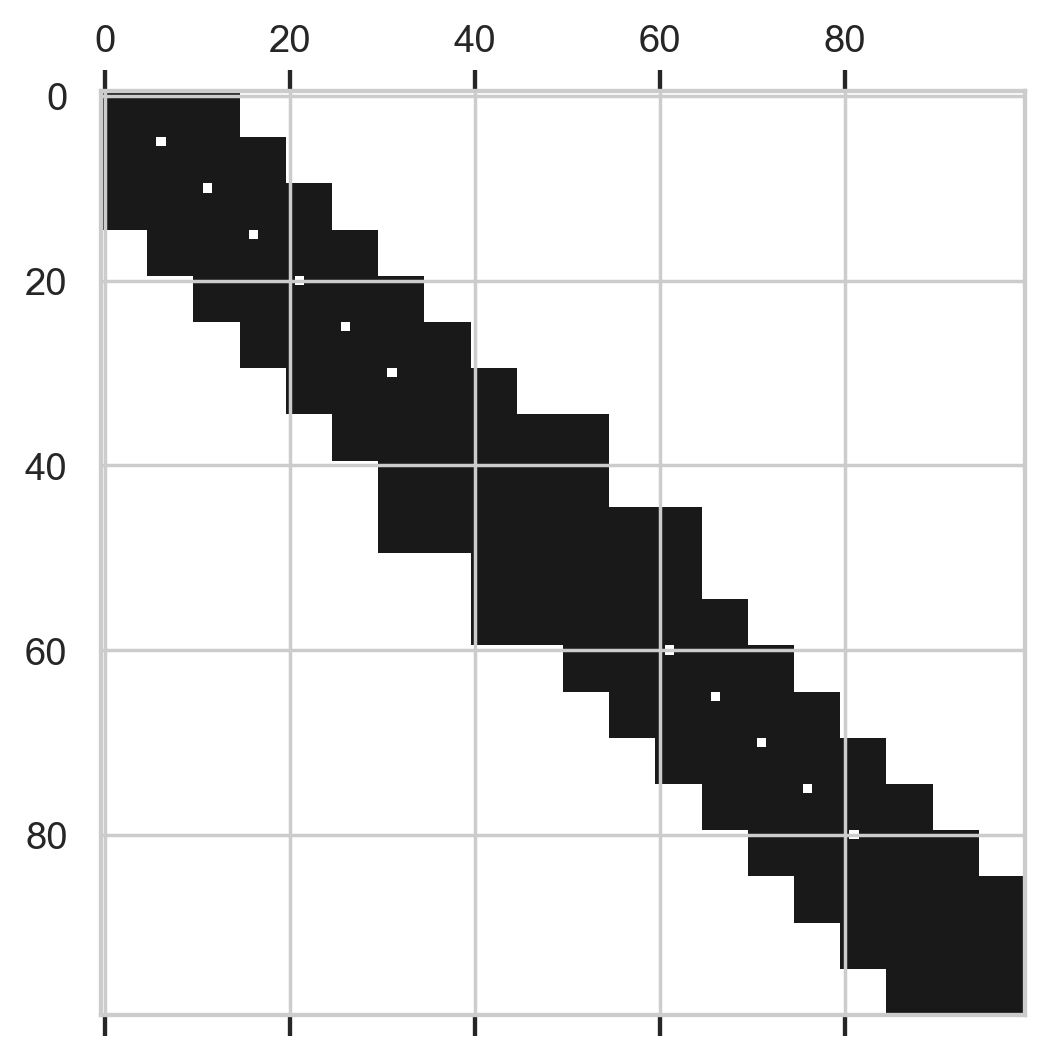

In [14]:
def mv_srd(u):
    U = np.reshape(u, (N, p+1))
    F = compute_F(U, srd=True)
    return F.flatten()

A = sp.LinearOperator( (N*(p+1), N*(p+1)), matvec=mv_srd )
Adense = A * np.eye(N*(p+1))
print("Condition number of A is:")
print(np.linalg.cond(Adense))
fig, ax = plt.subplots(dpi=250)
ax.spy(Adense)
fig.show()

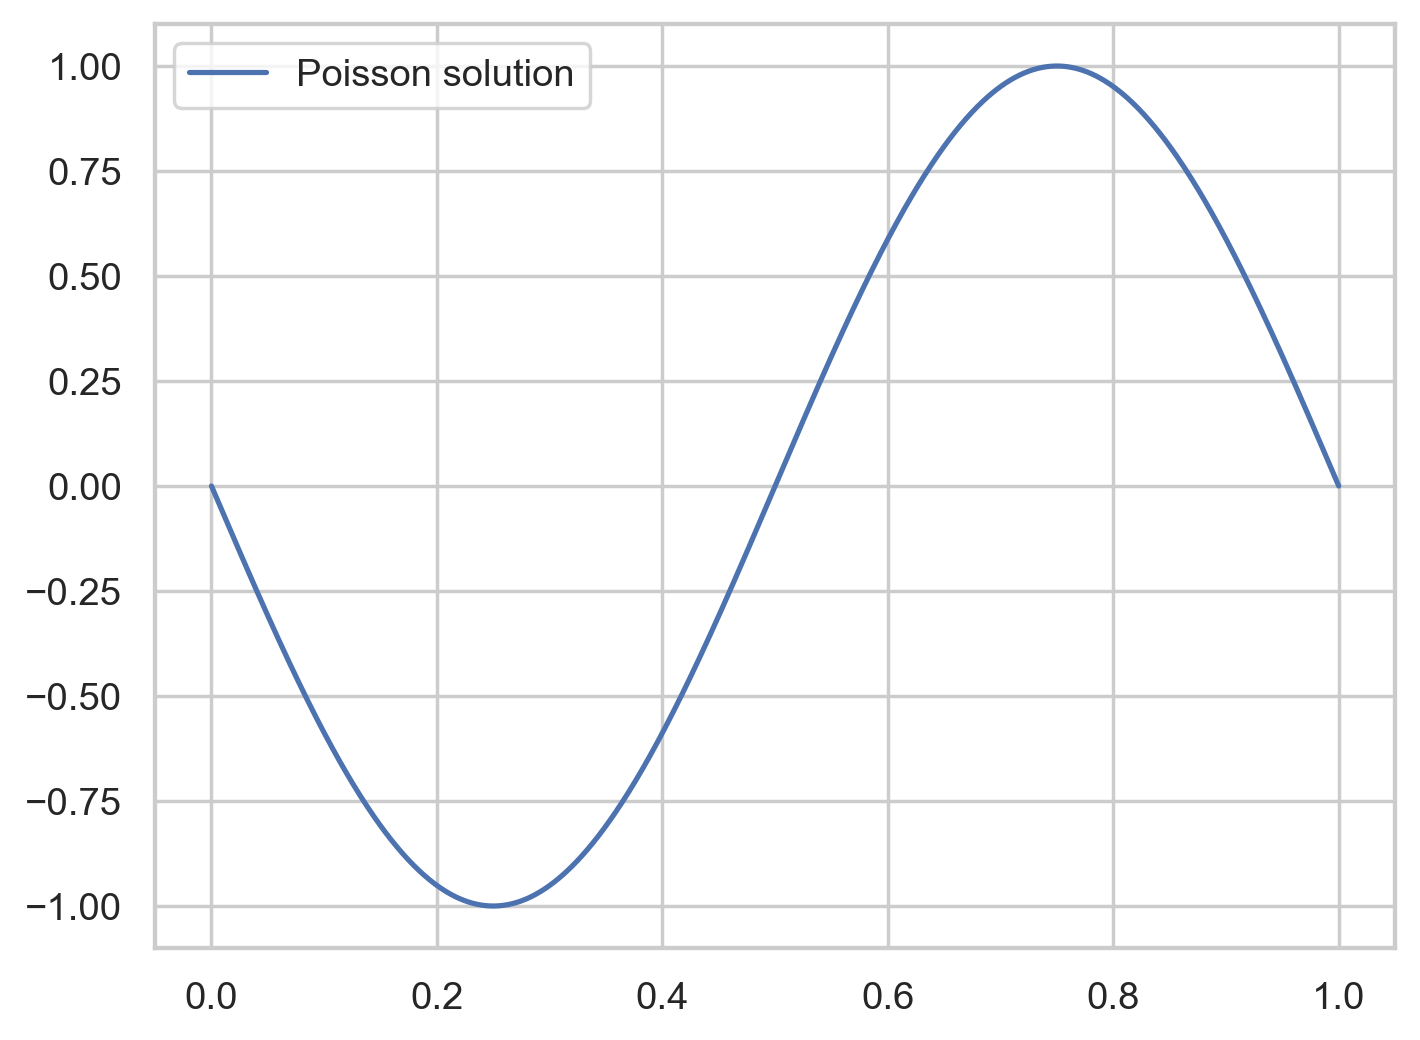

In [13]:
F = initialize(lambda x: (2*np.pi)**2 * np.sin(2*np.pi*x), nodes, h_local, p)
F = F.flatten()
U = np.linalg.solve(Adense, F)
U = np.reshape(U, (N, p+1))

func_U  = evaluate_sol(U, h_local, nodes)
xs      = np.linspace(0, L, 1000)
us      = do_op(func_U, xs)
fig, ax = plt.subplots(dpi=250)
ax.plot(xs, us, label="Poisson solution")
ax.legend()
plt.show()